In [2]:
import torch
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

In [18]:
fnames = glob("logs/*.txt")
fname = fnames[0]
def _get_metadata(fname):
    n_subjet, n_clusters, n_particles = fname.split("_")[1:]
    seed = int(n_particles.split("(")[1].split(")")[0])
    n_subjet, n_clusters, n_particles = int(n_subjet), int(n_clusters), int(n_particles.split("(")[0])
    return n_subjet, n_clusters, n_particles, seed
def get_metadata(fnames):
    return [_get_metadata(fname) for fname in fnames]

def parse_file(fname):
    n_subjet, n_clusters, n_particles, seed = _get_metadata(fname)
    with open(fname, "r") as f:
        emd_nn, emd_true, last_emd_nn, last_emd = f.readline().split(", ")
        emd_nn, emd_true, last_emd_nn, last_emd = float(emd_nn), float(emd_true), float(last_emd_nn), float(last_emd)
        pq = np.loadtxt(f)
        p = pq[:n_subjet]
        q = pq[n_subjet:]
        assert len(q) == n_clusters * n_particles    
    return emd_nn, emd_true, last_emd_nn, last_emd, p, q

def make_df(fnames):
    df = pd.DataFrame(get_metadata(fnames), columns=["n_subjet", "n_clusters", "n_particles", "seed"])
    df["emd_nn"], df["emd_true"], df["last_emd_nn"], df["last_emd"], df["p"], df["q"] = zip(*[parse_file(fname) for fname in fnames])
    return df

df = make_df(fnames)

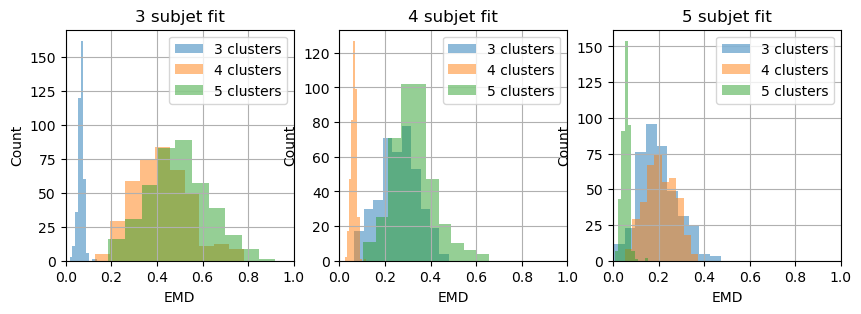

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, n_subjet in zip(axes.flatten(), range(3, 6)):
    for n_clusters in range(3, 6):
        df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)].last_emd_nn.hist(bins=10, alpha=0.5, label=f"{n_clusters} clusters", ax=ax)
    ax.legend()
    ax.set_title(f"{n_subjet} subjet fit")
    ax.set_xlabel("EMD")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 1)
plt.show()

In [54]:
# Ability to reconstruct jet center
from scipy.spatial.distance import cdist
evt = df.iloc[0]
p = evt.p
q = evt.q.reshape(evt.n_particles, evt.n_clusters, 2)
qmean = q.mean(axis=0)
cdist(p, qmean).min(axis=1)

array([[0.92257294, 2.31211055, 1.82718031, 3.08828599],
       [1.4582402 , 1.49879803, 1.01481102, 2.38372492],
       [2.32417592, 1.07095249, 0.84917757, 1.9562158 ],
       [3.26758697, 1.43090427, 1.55317931, 1.99284246]])

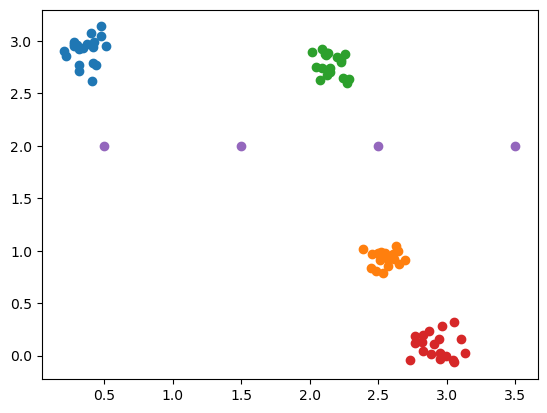

In [55]:
for i in range(4):
    plt.scatter(q[:, i, 0], q[:, i, 1], label=f"Cluster {i}")
plt.scatter(p[:, 0], p[:, 1], label="True")